In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, BatchNormalization, Bidirectional, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D,ConvLSTM2D,LSTM,GlobalAveragePooling2D, Reshape, Dense, Multiply, AveragePooling2D, UpSampling2D
from keras.layers import UpSampling2D, Input, Concatenate,TimeDistributed, Add, GlobalMaxPooling2D, Multiply, Permute, multiply,MaxPooling2D, MaxPooling3D, Dropout, Flatten, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau,EarlyStopping
from keras.metrics import Recall, Precision, Accuracy, MeanIoU
from keras import backend as K

In [3]:
height , width = 250,250
dataset_dir = r"C:\Users\DEEPAK YADAV\Downloads\fault_analysis2"
classes = []
subclasses = ['ia','ib','ic','va','vb','vc']
folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
for folder in folders:
    classes.append(folder)

In [5]:
classes

['abcfault',
 'abcgfault',
 'abfault',
 'acfault',
 'agfault',
 'bcfault',
 'bgfault',
 'cgfault',
 'nofault']

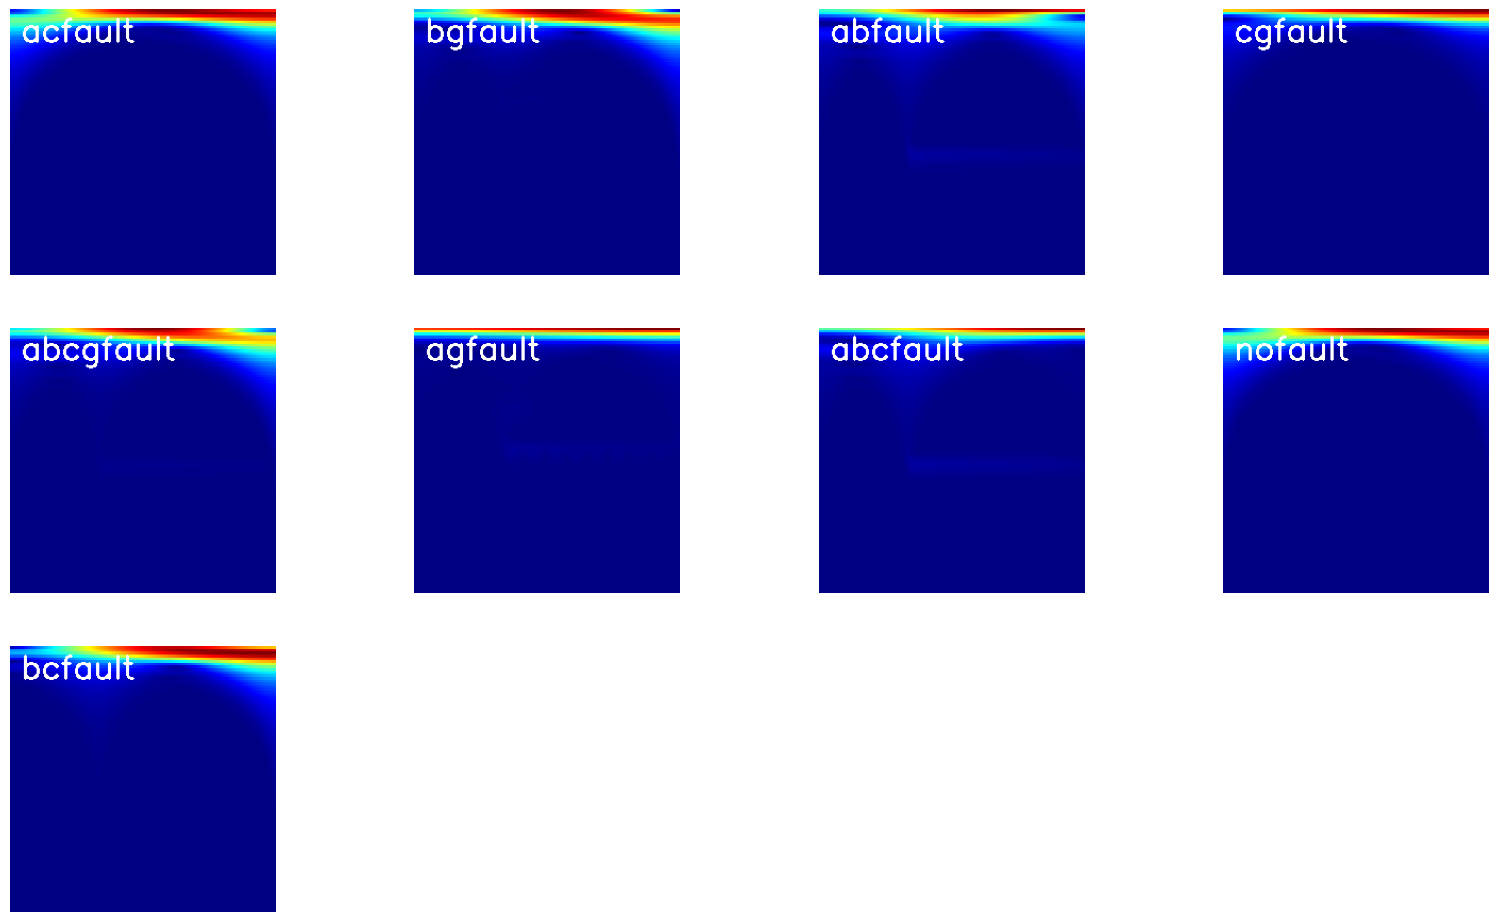

In [9]:

plt.figure(figsize=(20, 20))

all_classes_names = os.listdir(dataset_dir)
sample_size = min(20, len(all_classes_names))
random_range = random.sample(all_classes_names, sample_size)

for counter, selected_class_name in enumerate(random_range, 1):
    img_files_names_list = os.listdir(fr'C:\Users\DEEPAK YADAV\Downloads\fault_analysis2/{selected_class_name}')
    selected_img_file_name = random.choice(img_files_names_list)
    img = cv2.imread(fr'C:\Users\DEEPAK YADAV\Downloads\fault_analysis2/{selected_class_name}/{selected_img_file_name}')
    resize_img = cv2.resize(img,(height,width))

    rgb_frame = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
    resize_img = resize_img/255.0
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()


In [10]:
def preprocessing(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img,(height,width))
    img = img/255.0
    return img

In [13]:
def create_dataset():
    feature = []
    labels = []
    img_files_path = []
    for class_index, class_name in enumerate(classes):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(dataset_dir,class_name))
        for file_name in files_list:
            img_file_path = os.path.join(dataset_dir,class_name,file_name)
            img = preprocessing(img_file_path)
            feature.append(img)
            labels.append(class_index)
            img_files_path.append(img_file_path)
    feature = np.asarray(feature)
    labels = np.array(labels)
    return feature,labels,img_file_path


In [14]:
feature,label,img_files_path = create_dataset()

Extracting Data of Class: abcfault
Extracting Data of Class: abcgfault
Extracting Data of Class: abfault
Extracting Data of Class: acfault
Extracting Data of Class: agfault
Extracting Data of Class: bcfault
Extracting Data of Class: bgfault
Extracting Data of Class: cgfault
Extracting Data of Class: nofault


In [18]:
one_hot_encoded_labels = to_categorical(label)

In [20]:
features_train,features_test,labels_train,labels_test = train_test_split(feature,one_hot_encoded_labels,test_size=0.2,shuffle=True,random_state=27)

In [25]:
from tensorflow.keras import layers, models
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer to transition from convolutional to dense layers
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout to prevent overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    return model

In [26]:
model = create_cnn_model((height,width,3),9)

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      13,779,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,873,481 (52.92 MB)

 Trainable params: 13,873,481 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

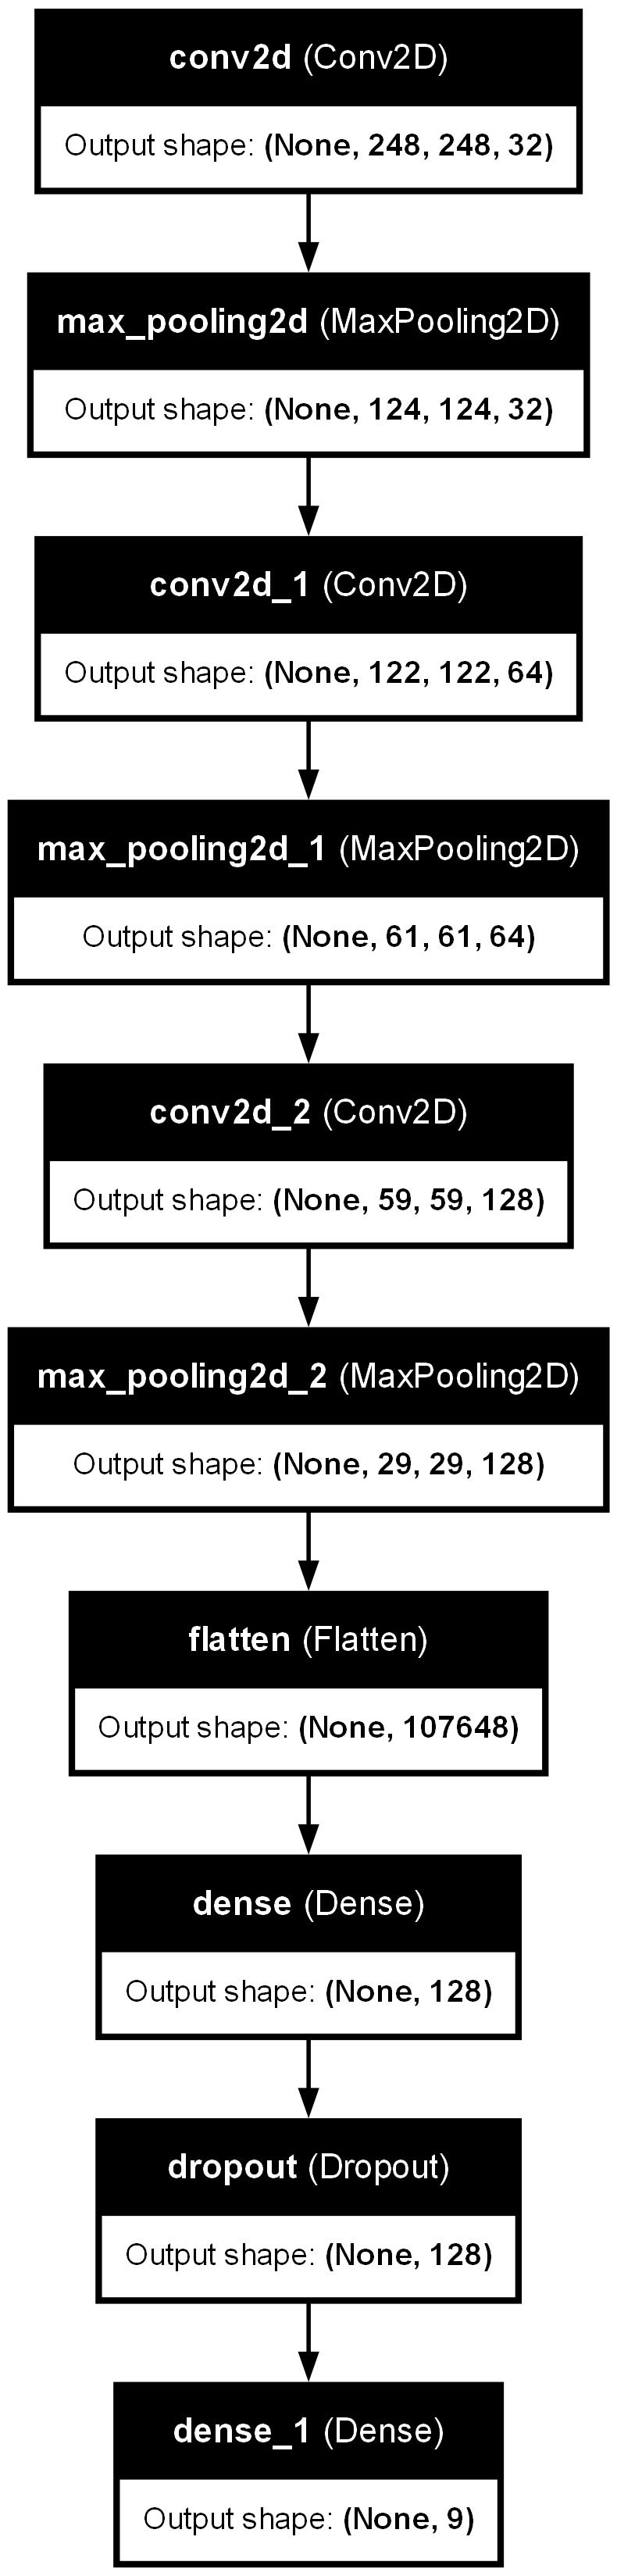

In [29]:
# without attention
plot_model(model, to_file = r"C:\Users\DEEPAK YADAV\Downloads\cnn.png",show_shapes= True,show_layer_names=True)

In [33]:
# Create an Instance of Early Stopping Callback
# without attention
import keras
from keras import layers
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
# opt = keras.optimizers.Adam(learning_rate=0.01)
opt = keras.optimizers.Nadam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name="nadam",

)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ["accuracy"])

# Start training the model. --> vary bacth size and epochs
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 500, batch_size = 16,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

MemoryError: Unable to allocate 2.95 GiB for an array with shape (4228, 250, 250, 3) and data type float32